In [1]:
import pandas as pd
import time
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torch
from torch.utils.data import random_split
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

<h3>Read the data sets from the pickle files into a dataframe</h3>

In [3]:
data_df = pd.read_pickle('data_df_2015-2020-18-endpoints-4-cols.pickle')
games_df = pd.read_pickle('games_df_2015-2020.pickle')
#data_df.to_csv('18-endpoints-4-cols.csv')

In [4]:
stds = data_df.std()
means = data_df.mean()
maxs = data_df.max()
mins = data_df.min()
print(stds)
print(means)
print(maxs)
print(mins)

opponent-points-per-game-col=2    5.543125
opponent-points-per-game-col=3    8.532674
opponent-points-per-game-col=5    5.920390
opponent-points-per-game-col=6    6.047800
points-per-game-col=2             5.917554
                                    ...   
offensive-rebounding-pct-col=6    2.943629
win-pct-all-games-col=2           0.171918
win-pct-all-games-col=3           0.311174
win-pct-all-games-col=5           0.199206
win-pct-all-games-col=6           0.192158
Length: 72, dtype: float64
opponent-points-per-game-col=2    104.503873
opponent-points-per-game-col=3    105.210054
opponent-points-per-game-col=5    103.325239
opponent-points-per-game-col=6    105.722405
points-per-game-col=2             104.510727
                                     ...    
offensive-rebounding-pct-col=6     23.021437
win-pct-all-games-col=2             0.499993
win-pct-all-games-col=3             0.499440
win-pct-all-games-col=5             0.575466
win-pct-all-games-col=6             0.421838
Lengt

<h2>standardizing the data<h2>

In [5]:
for col in data_df:
    print(col)
    print(means[col])
    data_df[col] = data_df[col].apply(lambda x: (x-means[col])/stds[col])

opponent-points-per-game-col=2
104.50387327086122
opponent-points-per-game-col=3
105.21005354752342
opponent-points-per-game-col=5
103.32523873270861
opponent-points-per-game-col=6
105.72240517626058
points-per-game-col=2
104.51072735385988
points-per-game-col=3
105.18036590807675
points-per-game-col=5
105.71267291387774
points-per-game-col=6
103.2932307005801
true-shooting-percentage-col=2
108.37900044622938
true-shooting-percentage-col=3
109.0175903614458
true-shooting-percentage-col=5
109.36618473895584
true-shooting-percentage-col=6
107.37962070504238
opponent-true-shooting-percentage-col=2
108.39617581436858
opponent-true-shooting-percentage-col=3
109.0478313253012
opponent-true-shooting-percentage-col=5
107.47680946006247
opponent-true-shooting-percentage-col=6
109.39869701026326
assists-per-game-col=2
22.546215975011158
assists-per-game-col=3
22.943257474341813
assists-per-game-col=5
23.09267291387773
assists-per-game-col=6
21.998701472556892
assists-per-possession-col=2
0.22382

In [6]:
data_df

opponent-points-per-game-col=2  \
2014-11-04 Atlanta                           -0.722313   
           Boston                             0.811118   
           Brooklyn                          -1.047040   
           Charlotte                         -2.436148   
           Chicago                           -0.866636   
...                                                ...   
2019-03-31 Sacramento                         1.857459   
           San Antonio                        1.045642   
           Toronto                            0.702876   
           Utah                               0.305987   
           Washington                         2.290428   

                        opponent-points-per-game-col=3  \
2014-11-04 Atlanta                           -0.552002   
           Boston                             0.444169   
           Brooklyn                          -0.762956   
           Charlotte                         -1.665369   
           Chicago                           -0.645759   
...                                                ...   
2019-03-31 Sacramento                         1.768490   
           San Antonio                        0.596524   
           Toronto                           -0.762956   
           Utah                               0.010541   
           Washington                         2.237276   

                        opponent-points-per-game-col=5  \
2014-11-04 Atlanta                           -1.912921   
           Boston                             0.282880   
           Brooklyn                          -3.095276   
           Charlotte                         -2.504098   
           Chicago                            1.803050   
...                                                ...   
2019-03-31 Sacramento                         1.600361   
           San Antonio                        0.434897   
           Toronto                            0.705150   
           Utah                               0.265989   
           Washington                         1.904395   

                        opponent-points-per-game-col=6  points-per-game-col=2  \
2014-11-04 Atlanta                            0.541948              -0.424285   
           Boston                             0.872647               0.589648   
           Brooklyn                          -0.036775               0.538951   
           Charlotte                         -1.607594              -2.452150   
           Chicago                           -2.186316               0.251670   
...                                                ...                    ...   
2019-03-31 Sacramento                         1.848208               1.620479   
           San Antonio                        1.484440               1.248704   
           Toronto                            0.608088               1.654277   
           Utah                               0.277389               1.130412   
           Washington                         2.294652               1.671176   

                        points-per-game-col=3  points-per-game-col=5  \
2014-11-04 Atlanta                  -0.363207              -0.567584   
           Boston                    0.322011               2.337087   
           Brooklyn                  0.287750               1.572700   
           Charlotte                -1.733643              -2.631429   
           Chicago                   0.093605               0.349681   
...                                       ...                    ...   
2019-03-31 Sacramento                1.349837               1.389247   
           San Antonio               1.201373               1.129355   
           Toronto                   1.429779               1.404535   
           Utah                      2.000794               1.022341   
           Washington                1.464040               1.756153   

                        points-per-game-col=6  true-shooting-percentage-col=2  \
2014-11-04 Atl

<h3>Convert the dataframes into a list 'training_data'
Each element of training data represents one game. Each element contains the home team and away team data for that date and a bool detailing if the home team won</h3>

In [7]:
training_data = []
for i in range(len(games_df)):
    try:
        game = games_df.loc[i]

        homeTeam, awayTeam = str(game.Home), str(game.Away)
        date_str = str(game.Date.date())
        home_index = (date_str, homeTeam) # Index to get the stats for a team on a certain date from data_df
        away_index = (date_str, awayTeam)
        home_stats = data_df.loc[home_index].to_numpy()
        home_stats = np.append(home_stats, [0.75]) # append 1 to array representing that this team was the home team
        away_stats = data_df.loc[away_index].to_numpy()
        away_stats = np.append(away_stats, [0.25])
        # array_to_append = np.array([ np.array([home_stats.to_numpy(), away_stats.to_numpy()]), game.DidHomeWin])
        # stats = np.array([home_stats.to_numpy(), away_stats.to_numpy()]) # make a 2d array for model eventually
        training_data.append([home_stats, away_stats, int(game.DidHomeWin)]) # [1, 0 ] if AWAY WON,and [0,1] if HOME WON
    except KeyError as e:
        pass
        print(date_str) 
        print(home_index)

2016-11-01
('2016-11-01', 'Cleveland')
2016-11-01
('2016-11-01', 'Indiana')
2016-11-01
('2016-11-01', 'Philadelphia')
2016-11-01
('2016-11-01', 'Detroit')
2016-11-01
('2016-11-01', 'Miami')
2016-11-01
('2016-11-01', 'Minnesota')
2016-11-01
('2016-11-01', 'New Orleans')
2016-11-01
('2016-11-01', 'San Antonio')
2016-11-01
('2016-11-01', 'Portland')
2016-11-02
('2016-11-02', 'Charlotte')
2016-11-02
('2016-11-02', 'Washington')
2016-11-02
('2016-11-02', 'Atlanta')
2016-11-02
('2016-11-02', 'Brooklyn')
2016-11-02
('2016-11-02', 'New York')
2016-11-02
('2016-11-02', 'Boston')
2016-11-02
('2016-11-02', 'Memphis')
2016-11-02
('2016-11-02', 'Utah')
2016-11-02
('2016-11-02', 'Phoenix')
2016-11-02
('2016-11-02', 'LA Clippers')
2019-11-01
('2019-11-01', 'Brooklyn')
2019-11-01
('2019-11-01', 'Indiana')
2019-11-01
('2019-11-01', 'Orlando')
2019-11-01
('2019-11-01', 'Boston')
2019-11-01
('2019-11-01', 'Chicago')
2019-11-01
('2019-11-01', 'Dallas')
2019-11-01
('2019-11-01', 'Sacramento')
2019-11-01
('

In [8]:
print(len(training_data))
len(training_data[0][0])

5270


73

<h3>Turn the list into tensors and then a TensorDataset</h3>

In [9]:
num_data_points = len(training_data[0][0])*2
x_vals = [x[0:2] for x in training_data]
x_vals = torch.FloatTensor(x_vals)
x_vals = x_vals.view(-1, num_data_points)
y_vals = [y[2] for y in training_data]
y_vals = torch.LongTensor(y_vals)
print(f'x_vals[0]: {x_vals[0]} \ny_vals[0]: {y_vals[0]}')
print(f'x_vals.shape: {x_vals.shape} \ny_vals.shape: {y_vals.shape}')

x_vals[0]: tensor([ 0.1797, -0.0598,  0.7896, -0.1691, -1.6072, -1.1969, -1.4848, -1.3856,
        -3.0056, -1.7867, -2.7659, -2.4810, -0.3640, -0.0875, -0.9498, -0.2174,
        -0.0194,  0.0998, -1.0809,  0.5330,  0.1024,  0.1986, -1.0809,  0.7516,
         0.9842,  0.1907,  0.8364,  1.0032, -1.2823, -0.3026, -2.2793, -0.7509,
         0.6568,  0.0702,  1.4477,  0.0552,  0.3079,  0.1655,  0.0414,  0.2159,
        -2.2374, -1.5383,  1.4009, -2.7338, -2.0152, -1.3272, -1.7505, -1.6588,
        -2.0085, -1.1189, -2.4015, -1.3497, -1.3342, -0.7445, -1.2372, -1.3176,
         1.3746,  0.0515,  4.2741, -0.1607, -1.3746, -0.0515, -4.2740,  0.1607,
         1.3342,  0.7445,  1.2373,  1.3176, -1.4541, -0.5349, -2.8888, -0.4623,
         0.7500, -0.3435,  0.0574, -0.1394, -0.4998, -0.6271, -0.7058, -0.8733,
        -0.3214, -0.2216, -0.5233, -0.2214, -0.0780,  0.2356,  0.1421,  1.6264,
        -0.7615, -0.3963, -0.6276, -0.0324, -0.5320, -0.3218, -0.6946,  0.4505,
        -0.7430, -0.7505, -0.

In [10]:
dataset = TensorDataset(x_vals, y_vals)
lenght = len(dataset)
train_ds, val_ds = random_split(dataset, [lenght-500, 500])

In [11]:
std_loader = DataLoader(train_ds, batch_size=len(train_ds), num_workers=1)
data = next(iter(std_loader))

In [12]:
# plt.hist(data[0]) #this takes a looonnngnggg time

In [13]:
batch_size = 64
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

In [14]:
import torch.nn as nn
import torch.nn.functional as F

In [15]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [16]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [20]:

class BBallNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(146, 64) 
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64,2)
        
    def forward(self, data):
        out = self.fc1(data)
        out = torch.sigmoid(out)
        out = self.fc2(out)
        out = torch.sigmoid(out)
        out = self.fc3(out)
        out = torch.sigmoid(out)
        out = self.fc4(out)
        out = torch.sigmoid(out)
        out = self.fc5(out)
        return out
    
    def training_step(self, batch):
        data, win_labels = batch 
        out = self(data)                  # Generate predictions
        loss = F.cross_entropy(out, win_labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate losszz
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [21]:
def fit(epochs, learning_rate, model, train_loader, val_loader, opt_func=torch.optim.AdamW): # mess around with optimizer
    optimizer = opt_func(model.parameters(), learning_rate)
    history = [] # for recording epoch-wise results
    
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
        #adjust_learning_rate(learning_rate, optimizer, epoch)

    return history

In [22]:
def adjust_learning_rate(lr, optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = lr * (0.1 ** (epoch//20))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [23]:
BBModel = BBallNet()

In [24]:
history = fit(100, 0.0001, BBModel, train_loader, val_loader) #0.0001

Epoch [0], val_loss: 0.6769, val_acc: 0.5906
Epoch [1], val_loss: 0.6761, val_acc: 0.5906
Epoch [2], val_loss: 0.6754, val_acc: 0.5906
Epoch [3], val_loss: 0.6741, val_acc: 0.5906
Epoch [4], val_loss: 0.6714, val_acc: 0.5906
Epoch [5], val_loss: 0.6670, val_acc: 0.5906
Epoch [6], val_loss: 0.6581, val_acc: 0.5906
Epoch [7], val_loss: 0.6457, val_acc: 0.6585
Epoch [8], val_loss: 0.6289, val_acc: 0.6674
Epoch [9], val_loss: 0.6180, val_acc: 0.6713
Epoch [10], val_loss: 0.6137, val_acc: 0.6747
Epoch [11], val_loss: 0.6130, val_acc: 0.6654
Epoch [12], val_loss: 0.6132, val_acc: 0.6596
Epoch [13], val_loss: 0.6121, val_acc: 0.6635
Epoch [14], val_loss: 0.6121, val_acc: 0.6654
Epoch [15], val_loss: 0.6145, val_acc: 0.6513
Epoch [16], val_loss: 0.6110, val_acc: 0.6615
Epoch [17], val_loss: 0.6113, val_acc: 0.6596
Epoch [18], val_loss: 0.6107, val_acc: 0.6615
Epoch [19], val_loss: 0.6109, val_acc: 0.6635
Epoch [20], val_loss: 0.6107, val_acc: 0.6576
Epoch [21], val_loss: 0.6123, val_acc: 0.657

Text(0.5, 1.0, 'Loss vs. No. of epochs')

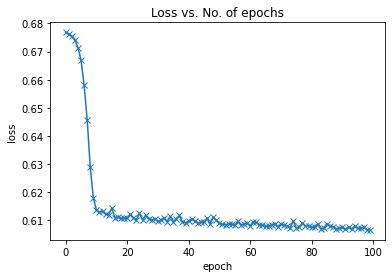

In [25]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs')

Text(0.5, 1.0, 'Accuracy vs. No. of epochs')

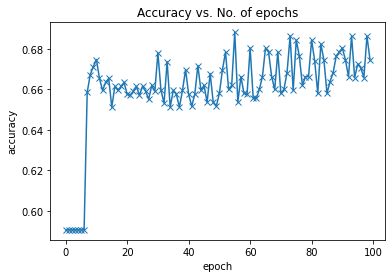

In [26]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs')